# Fashion-MNIST Optimization Experiment
This notebook demonstrates:
- Data loading & preprocessing
- Baseline CNN model training
- Hyperparameter tuning
- Model compression with Dropout
- Conversion to TensorFlow Lite
- Evaluation (accuracy, loss curves, confusion matrix)

In [1]:
import os, time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Load & preprocess data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0
x_train = np.expand_dims(x_train, -1)
x_test  = np.expand_dims(x_test, -1)
num_classes = 10
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes)
y_test_cat  = tf.keras.utils.to_categorical(y_test, num_classes)

class_names = ["T-shirt", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [2]:
# Build CNN model function
def build_cnn(filters1=32, filters2=64, dense_units=128, dropout_rate=0.0):
    model = models.Sequential([
        layers.Input(shape=(28,28,1)),
        layers.Conv2D(filters1, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(filters2, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),
        layers.Flatten(),
        layers.Dense(dense_units, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

def compile_and_train(model, lr=1e-3, batch_size=128, epochs=5):
    model.compile(optimizer=optimizers.Adam(learning_rate=lr),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    history = model.fit(x_train, y_train_cat, validation_split=0.1,
                        batch_size=batch_size, epochs=epochs, verbose=1)
    return history


In [3]:
# Baseline model training
baseline = build_cnn()
baseline.summary()
history_base = compile_and_train(baseline)
eval_base = baseline.evaluate(x_test, y_test_cat, verbose=0)
print("Baseline test accuracy:", eval_base[1])


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 421,642 (1.61 MB)

 Trainable params: 421,642 (1.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 57s 132ms/step - accuracy: 0.7406 - loss: 0.7451 - val_accuracy: 0.8668 - val_loss: 0.3766
Epoch 2/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 81s 130ms/step - accuracy: 0.8801 - loss: 0.3375 - val_accuracy: 0.8853 - val_loss: 0.3171
Epoch 3/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 82s 130ms/step - accuracy: 0.8956 - loss: 0.2884 - val_accuracy: 0.9010 - val_loss: 0.2727
Epoch 4/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 82s 130ms/step - accuracy: 0.9085 - loss: 0.2523 - val_accuracy: 0.9067 - val_loss: 0.2593
Epoch 5/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 81s 127ms/step - accuracy: 0.9188 - loss: 0.2247 - val_accuracy: 0.9117 - val_loss: 0.2389
Baseline test accuracy: 0.9061999917030334


In [4]:
# Hyperparameter tuning - Model 1 (different LR & batch size)
model1 = build_cnn()
history1 = compile_and_train(model1, lr=5e-4, batch_size=64)
eval1 = model1.evaluate(x_test, y_test_cat, verbose=0)
print("Model1 test accuracy:", eval1[1])

# Model 2 (more filters, dropout for regularization)
model2 = build_cnn(filters1=64, filters2=128, dense_units=256, dropout_rate=0.5)
history2 = compile_and_train(model2, lr=1e-3, batch_size=128)
eval2 = model2.evaluate(x_test, y_test_cat, verbose=0)
print("Model2 test accuracy:", eval2[1])


Epoch 1/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 61s 70ms/step - accuracy: 0.7568 - loss: 0.6987 - val_accuracy: 0.8747 - val_loss: 0.3506
Epoch 2/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 58s 69ms/step - accuracy: 0.8804 - loss: 0.3341 - val_accuracy: 0.8880 - val_loss: 0.3185
Epoch 3/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 60s 71ms/step - accuracy: 0.8985 - loss: 0.2818 - val_accuracy: 0.9002 - val_loss: 0.2841
Epoch 4/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 82s 71ms/step - accuracy: 0.9068 - loss: 0.2561 - val_accuracy: 0.9035 - val_loss: 0.2602
Epoch 5/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 80s 68ms/step - accuracy: 0.9155 - loss: 0.2303 - val_accuracy: 0.9032 - val_loss: 0.2614
Model1 test accuracy: 0.8970999717712402
Epoch 1/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 158s 372ms/step - accuracy: 0.7422 - loss: 0.7036 - val_accuracy: 0.8753 - val_loss: 0.3331
Epoch 2/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 148s 350ms/step - accuracy: 0.8794 - loss: 0.3318 - val_accuracy: 0.9000 - val_loss: 0.2737
Epoch 3/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 200s 347ms/st

In [5]:
# Convert best model to TFLite for deployment
converter = tf.lite.TFLiteConverter.from_keras_model(model2)
tflite_model = converter.convert()
with open("model2.tflite", "wb") as f:
    f.write(tflite_model)

print("Original Keras model size: %.2f MB" % (os.path.getsize("model2.tflite")/1024/1024))


Saved artifact at '/tmp/tmp0z4ytgk9'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='keras_tensor_18')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  132337455871568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132337455870800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132337455866768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132337455868880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132337455868304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132337412729040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132337412727888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132337412729616: TensorSpec(shape=(), dtype=tf.resource, name=None)
Original Keras model size: 6.42 MB


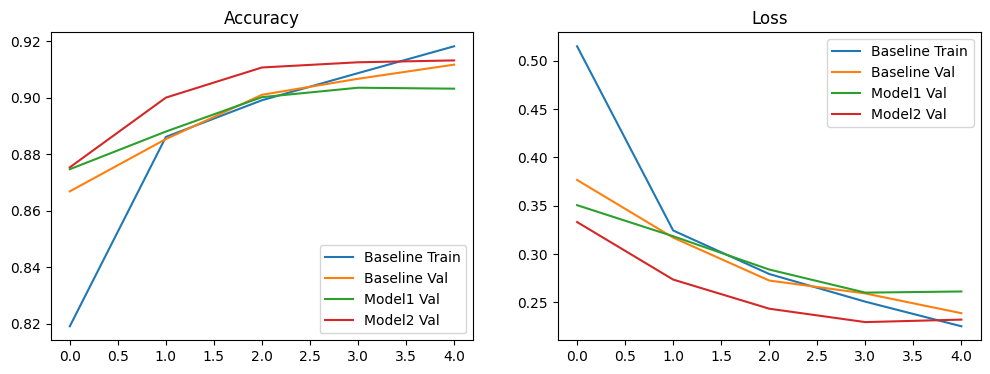

In [6]:
# Plot accuracy & loss curves
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history_base.history['accuracy'], label='Baseline Train')
plt.plot(history_base.history['val_accuracy'], label='Baseline Val')
plt.plot(history1.history['val_accuracy'], label='Model1 Val')
plt.plot(history2.history['val_accuracy'], label='Model2 Val')
plt.legend(); plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(history_base.history['loss'], label='Baseline Train')
plt.plot(history_base.history['val_loss'], label='Baseline Val')
plt.plot(history1.history['val_loss'], label='Model1 Val')
plt.plot(history2.history['val_loss'], label='Model2 Val')
plt.legend(); plt.title("Loss")
plt.show()


313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step


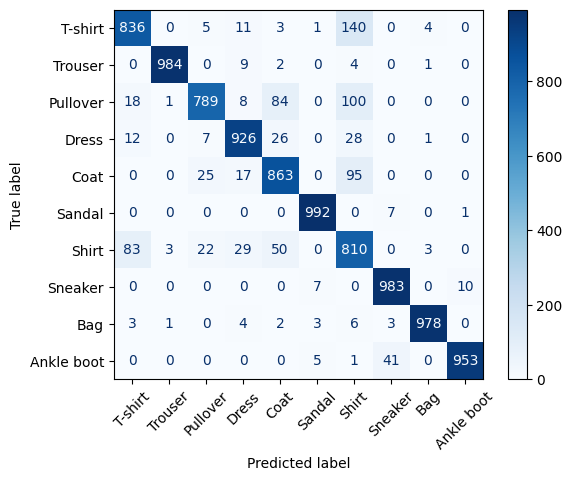

              precision    recall  f1-score   support

     T-shirt       0.88      0.84      0.86      1000
     Trouser       0.99      0.98      0.99      1000
    Pullover       0.93      0.79      0.85      1000
       Dress       0.92      0.93      0.92      1000
        Coat       0.84      0.86      0.85      1000
      Sandal       0.98      0.99      0.99      1000
       Shirt       0.68      0.81      0.74      1000
     Sneaker       0.95      0.98      0.97      1000
         Bag       0.99      0.98      0.98      1000
  Ankle boot       0.99      0.95      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.92      0.91      0.91     10000
weighted avg       0.92      0.91      0.91     10000



In [7]:
# Confusion matrix for best model
y_pred = np.argmax(model2.predict(x_test), axis=1)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(xticks_rotation=45, cmap='Blues')
plt.show()

print(classification_report(y_test, y_pred, target_names=class_names))
